# Sentiment classification with LLMs

--------------

**a) Goal:**

In this notebook we demonstrate how to use the following pre-trained LLMs

* **M1)** `Qwen2.5-1.5B-Instruct` ("medium").
* **M2)** `Qwen2.5-0.5B-Instruct` ("small").
  
to perform sentiment analysis on movie reviews, using the HuggingFace library and a variety of methods (3).
This notebook is designed to run on CUDA, MPS/Silicon or Intel chips. We recommend however using a CUDA-enabled
or a Silicon M2+-enabled host for reasonable inference speeds.

For more information on the Qwen models, please refer to this [page](https://qwenlm.github.io/blog/qwen2.5/).

We will implement a number of methods using PyTorch and the HuggingFace Python libraries, detailed below.

--------------

**b) Dataset:** 

We will be using the [IMDB sentiment analysis](https://huggingface.co/datasets/ajaykarthick/imdb-movie-reviews) dataset from HuggingFace. This is a baöanced dataset of 50,000 (80% train, 20% test) IMDB movie reviews, of which 50% labelled as **positive** (label $1$ in the dataset) and 50% as **negative** (label $0$). Given that we will be fine-tuning M1 or M2, we will be using only a portion of the test set in this demo.

--------------

**c) Evaluation:** 

As this is a classification task, we're gonna be using traditional classification evaluation metrics (available in e.g. Scikit-learn) **precision**, **recall**, **F1-score**

$$
P = TP/(TP+FP) \qquad R = TP/(TP+FN) \qquad F_1 = 2PR/(P+R)
$$

and in particular **accuracy** the key metric we'll be using to compare performnance across all experiments:

$$
Acc = TP/(TP+FP+TN+FN)
$$

Additionally, we'll measure how many input words per second each model process, per evaluation method (**throughput**), although **we warn that thoughput numbers will vary between hosts** (although not their proportion). We will be using Scikit-learn's `classification_report`
method (cf. [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)), that reports precision, recall, F1-score a) for each label, b) as a macro-average and c) as a weighted micro-average (weighted by label or class balance in the gold set).

--------------

**d) Structure:** 

This notebook is broken down into the following blocks:

* Library imports and instatiation of models and tokenizers on host device (GPU or CPU).
* Downloading and sampling of test corpus.
* Experiments:
   - Experiment 1) Zero-shot experiment with precision, recall, F1-score and accuracy scores. Additionally, we include basic profiling (tokens per second).
   - Experiment 2) Log-likelihood experiment, with identical evaluation methodology.
   - Experiment 3) 5-shot in context learning experiment, with identical evaluation methodology.
   - Experiment 4) with sampling, optimizing temperature $\tau$ and $\text{top}_k$, with identical evaluation methodology.
   - Experiment 5) using chain-of-thought (CoT), a method used in reasoning tasks but that is known to sometimes
     improve on classification peformance for LLMs.
* Discussion and error analysis (including confusion matrixes).
* Appendix with additional plots.

-------------

**e) Notes:**

1. Please note that results may vary between runs and hosts, as we are randomly sampling the data to derive a subset of 500 reviews for the experiments.
2. This notebook was run on a Apple M2 MacBook Air (2022) with 24GB of RAM, using one of its GPU cores (via the so-called MPS driver). Time meaasurements may vary due to the differences in the host and the device. In particular, using a CPU may increase inference runetime ten-fold.

--------------
## Setup

### Import libraries

In [498]:
import torch, transformers
import time, os
import numpy as np

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [150]:
from datasets import load_dataset
import pandas as pd

In [4]:
from sklearn.metrics import classification_report

In [284]:
from sklearn import metrics
from torchinfo import summary

In [478]:
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import f1_score as agreement

In [18]:
import warnings
warnings.filterwarnings("ignore")

### Set up device and instantiate models and tokenizers

As device we use either:

* a CUDA (NVIDIA GPU) or MPS (Apple Silicon GPU) device, or
* if neither is available on the host, the CPU.

We're gonna run experiments on two LLMs of the Qwen2.5 family with 1.B and 500M parameters. Here we download them, together with their BPE tokenizers and instantiate them.

In [302]:
'''
Set up device - one of

    - CUDA (NVIDIA GPU)
    - MPS (Silicon GPU)
    - CPU
'''
if torch.cuda.is_available():
    print('Using NVIDIA / CUDA GPU')
    torch.device('cuda')
elif torch.backends.mps.is_available():
    print('Using Silicon / MPS GPU')
    torch.device('mps')
else:
    print(f'Using {os.cpu_count()} CPUs')
    torch.device('cpu')

Using Silicon / MPS GPU


In [7]:
model_checkpoint_medium_x = "Qwen/Qwen2.5-1.5B-Instruct"
model_checkpoint_small_x  = "Qwen/Qwen2.5-0.5B-Instruct"

In [8]:
#%%capture
model_m = AutoModelForCausalLM.from_pretrained(
    model_checkpoint_medium_x,
    device_map="auto",
    torch_dtype="auto"
)

In [9]:
%%capture
model_s = AutoModelForCausalLM.from_pretrained(
    model_checkpoint_small_x,
    torch_dtype="auto",
    device_map="auto"
)

In [294]:
# Uncomment to visualize model statistics
# Inference in these models functions at a 16-bit precision level
# summary(model_m, verbose=0)

In [295]:
# Uncomment to visualize model statistics
# Visualize model statistics
# Inference in these models functions at a 16-bit precision level
# summary(model_s, verbose=0)

In [10]:
%%capture
tokenizer_m = AutoTokenizer.from_pretrained(model_checkpoint_medium_x)

In [292]:
print(f'The 1.5B model has a vocabulary of {tokenizer_m.vocab_size} tokens.')

The 1.5B model has a vocabulary of 151643 tokens.


In [11]:
%%capture
tokenizer_s = AutoTokenizer.from_pretrained(model_checkpoint_small_x)

In [293]:
print(f'The 500M model has a vocabulary of {tokenizer_s.vocab_size} tokens.')

The 500M model has a vocabulary of 151643 tokens.


--------------
## Download IMDB dataset, and derive sample

#### A. Download and inspect

We download the IMDB movie reviews dataset, and focus on a small sample of ~500 reviews (50% positive, 50% negative) for our experiments, derived from the test set.

In [20]:
%%capture
dataset = load_dataset("ajaykarthick/imdb-movie-reviews")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [142]:
dataset

DatasetDict({
    train: Dataset({
        features: ['review', 'label'],
        num_rows: 40000
    })
    test: Dataset({
        features: ['review', 'label'],
        num_rows: 10000
    })
})

In [22]:
# We're only interested in the test set, as we don't plan to train any model
df_pandas = pd.DataFrame(dataset['test'])

In [296]:
# Uncomment to visualize data distribution
# Label distribution is 50% for negatives and 50% for positives
# df_pandas['label'].value_counts()

In [92]:
%%capture
# We derive a stratified random sample of 500 data points (5% of the test set)
df_sample = df_pandas.groupby(['label']).apply(lambda f: f.sample(frac=0.05))

In [297]:
# Uncomment to visualize data distribution
# Label distribution should be the same as before
# df_sample.label.value_counts()

In [298]:
# We create human readable sentiment labels
df_sample['sentiment'] = df_sample['label'].map({0:'negative', 1:'positive'})

#### B. Collect corpus statistics

We count how many words (for simplicity we tokenize by whitespace) there are per sentence in our test set (average, minimum and maximum), as well as the total number of words and sentences.

In [95]:
def corpus_stats(corpus:list[str])->tuple[int,float,int,int,int]:
    '''
    Corpus statistics (whitespace tokenization)
    
    Arguments:
        - corpus: list of strings
    Returns:
        - number of sentences
        - average number of tokens per sentence
        - total number of words
        - max number of tokens per sentence
        - min number of tokens per sentence
    '''
    tot_sents  = len(corpus)
    n_tokens   = []
    tot_words  = 0
    for sent in corpus:
        n_tokens.append(len(sent.split(' ')))
        tot_words += len(sent.split(' '))
    # Print stats
    print(f'Number of sentences:                  {tot_sents}')
    print(f'Average number of words per sentence: {sum(n_tokens)/tot_sents}')
    print(f'Max number of words per sentence:     {max(n_tokens)}')
    print(f'Min number of words per sentence:     {min(n_tokens)}')
    print(f'Total number of words:                {tot_words}')
    return tot_sents, sum(n_tokens)/tot_sents, tot_words, max(n_tokens), min(n_tokens)

In [96]:
total_sentences, avg_words, total_words, max_words, min_words = corpus_stats(list(df_sample.review.values))

Number of sentences:                  500
Average number of words per sentence: 231.512
Max number of words per sentence:     1066
Min number of words per sentence:     30
Total number of words:                115756


----------------
## Experiments

### Method 1) zero-shot learning

In **zero-shot learning**, we want the LLMs to detect the sentiment of an input prompt $t$ as
the most likely continuation of $t$, without any fine-tuning of the models themselves to the domain or task. I.e., express classification as simple text (one token) text generation task:

\begin{equation}
   c^* = \text{argmax}_{c \in V} \ln P(c|t) \tag{P}
\end{equation}

where $V$ is the model vocabulary. The expectation is that $c$ - the most likely continuation - is the word **positive** or **negative**. 
This kind of inference is also known as **greedy decoding**, as the model returns always the most likely next token. Expressing classification in this manner is known to work quite well for large LLMs like GPT-4. Given that M1 is 3 times larger than M2, one would expect that accuracy is higher for M1. 

The intuition here is to rely on the learned knowledge and reasoning capabilities (including, classification) acquired by the LLM during pre-training and instruction tuning resp., to generalize and solve an unseen task.  

Thus, given an input text `I` we prompt the model with the following prompt string $t$ =  
```
"What is the sentiment of the following text, reply 'positive' or 'negative': " + I
```
and use functions to encode text, call models and decode answers, using greedy decoding (equation ($\text{P}$)).

While this method works well for GPT-4, it yields overall poor results (less than 5% accuracy) for models M1 and M2, even if M1 is marginally better (4% vs. 3%).

In [89]:
def encode_input_zero(input_prompt:str,
                 tokenizer:transformers.AutoTokenizer,
                 model:transformers.AutoModelForCausalLM)->torch.Tensor:
    '''
    Function for parsing prompts embedded in conversation messages

    Arguments:
        - input_prompt:  input query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
    Returns:
        - tensor
    '''
    # The 'user' message is used to query the model with a sentiment prompt.
    messages = [
        {"role": "system", "content":
                "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content":
                "What is the sentiment of the following text, reply 'positive' or 'negative': " + input_prompt}
    ]
    # Transforms message JSON into a plain text string in the model's input format.
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    # Returns a tensor.
    return tokenizer([text],
                      return_tensors = 'pt'
                    ).to(model.device)

In [208]:
def generate_response(input_prompt:str,
                      tokenizer:transformers.AutoTokenizer,
                      model:transformers.AutoModelForCausalLM,
                      length:int=1)->str:
    '''
    Function for generating responses

    Arguments:
        - input_prompt:  query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
        - length:        integer used to cap the length of the output sequence (1 token or word by default)
    Returns:
        - string (label)
    '''
    # We encode inputs into a tensor.
    model_inputs = encode_input_zero(input_prompt, tokenizer, model)
    # We use greedy decoding to generate the labels.
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=length
    )
    # We decode the returned tensor into a string and
    # Return it lower-cased.
    generated_ids = [
        output_ids[len(input_ids):] for input_ids,
            output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response.lower()

We process our sample with both models, and measure for each model:
 - throughput
 - model performanace.

In [97]:
start = time.time()
df_sample['response_m'] = df_sample.review.apply(lambda x: generate_response_zero(str(x), tokenizer_m, model_m))
end = time.time()
print(f'Time taken: {end-start}s')
med_time = end-start

Time taken: 504.82461190223694s


In [98]:
start = time.time()
df_sample['response_s'] = df_sample.review.apply(lambda x: generate_response_zero(str(x), tokenizer_s, model_s))
end = time.time()
print(f'Time taken: {end-start}s')
small_time = end-start

Time taken: 308.7607321739197s


In [99]:
print(f'Time per word for 1.5B model: {total_words / med_time} words per second')
print(f'Time per word for 500 model : {total_words / small_time} words per second')

Time per word for 1.5B model: 229.29943840063214 words per second
Time per word for 500 model : 374.9051868901406 words per second


In [101]:
print(classification_report(df_sample.sentiment, df_sample.response_m, zero_division=0))

              precision    recall  f1-score   support

       based       0.00      0.00      0.00         0
    negative       0.04      0.04      0.04       250
    positive       0.04      0.03      0.03       250
         the       0.00      0.00      0.00         0
          to       0.00      0.00      0.00         0

    accuracy                           0.04       500
   macro avg       0.02      0.01      0.02       500
weighted avg       0.04      0.04      0.04       500



In [102]:
print(classification_report(df_sample.sentiment, df_sample.response_s, zero_division=0))

              precision    recall  f1-score   support

       based       0.00      0.00      0.00         0
    negative       0.11      0.02      0.03       250
    positive       0.06      0.04      0.05       250
         the       0.00      0.00      0.00         0

    accuracy                           0.03       500
   macro avg       0.04      0.01      0.02       500
weighted avg       0.09      0.03      0.04       500



### Method 2) log-likelihood queries (GPT-3 style classification)

Here the idea is to model classification as a discriminative task, vs. a text generation task as before. Here we're going to try a trick from OpenAI's original GPT-3 paper:

>On tasks that involve choosing one correct completion from several options (multiple choice), we provide K examples
of context plus correct completion, followed by one example of context only, and compare the LM likelihood of
each completion.
>
>(Language Models are Few-Shot Learners, p. 10, https://arxiv.org/abs/2005.14165)

I.e. so-called "likelihood queries", where, instead of prompting the model to generate a sentiment continuation, we ask it which label
impacts (**conditions**) most its next token distribution (via greedy decoding):

\begin{equation}
    c^* = \text{argmax}_{c \in \{+,-\}} \ln P(\_|t,c).  \tag{P'}
\end{equation}

Basically, we're appending the label to the prompt, and disregarding the model continuation ($\_$ can be any token). This construct emulates a softmax layer in a standard classifier. While this doubles the inference costs as you need to pit $P(\_|t,+)$ against $P(\_|t,-)$, prediction accuracy increases.

The intuition here is that, even if the LLM's knowledge and reasoning capabilities might be insufficient for pure zero-shot learning, they are more than sufficient to understand which label (negative or positive) **is more consistent** with the input prompt $t$ via their effects on continuation likelihoods. Thus emulating the output softmax layer of a classification multi-layered perceptron. 

In order to do so, given a input `I` and a sentiment label `L` we define as input prompt $t,c=$
```  
"Is the labelling of this prompt correct:" + I + " " + L + "."
```
We also modify the decoding function so that it returns the logit score of the continuations, and implement equation $(\text{P'})$.

We can observe that this method is quite effective, yielding a maximum accuracy of 29%. This score is actually higher than the reported 7-10% classification (MMLU) accuracy for models M1 and M2 in the HuggingFace leaderboard. Although, paradoxically M2 beats M1.

In [215]:
def encode_sentiment(input_prompt:str,
                    tokenizer:transformers.AutoTokenizer,
                    model:transformers.AutoModelForCausalLM,
                    sentiment:str)->torch.Tensor:
    '''
    Function for parsing labelled prompts

    Arguments:
        - input_prompt:  input query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
        - sentiment:     sentiment label - 'positive' or 'negative' (string)
    Returns:
        - tensor
    '''
    messages = [
        {"role": "system", "content":
                "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content":
                "Is the labelling of this prompt correct:" + input_prompt + " " + sentiment + "."}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    return tokenizer([text],
                      return_tensors = 'pt'
                    ).to(model.device)

In [206]:
def get_sentiment_logit(input_prompt:str,
                      tokenizer:transformers.AutoTokenizer,
                      model:transformers.AutoModelForCausalLM,
                      sentiment:str,
                      length:int=1)->float:
    '''
    Function for generating responses with likelihoods

    Arguments:
        - input_prompt:  query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
        - sentiment:     sentiment label - 'positive' or 'negative' (string)
    Returns:
        - logit (float)
    '''
    # Note that we add a sentiment label here.
    model_inputs = encode_sentiment(input_prompt, tokenizer, model, sentiment)
    # Here, instead of generating a label, or text, we only focus
    # on returning the likelihood of the predicted (best) next token (a float).
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=length,
        output_scores=True,
        do_sample=False,
        return_dict_in_generate=True,
        return_legacy_cache=True
    )
    return generated_ids.scores[0][0][0]

In [210]:
def get_sentiment(input_prompt:str,
                  tokenizer:transformers.AutoTokenizer,
                  model:transformers.AutoModelForCausalLM)->str:
    '''
    Function to classify sentiment.
    Implements equation (P') above.

    Arguments:
        - input_prompt:  query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
    Returns:
        - string (sentiment label)
    '''
    pos = get_sentiment_logit(input_prompt, tokenizer, model, 'positive')
    neg = get_sentiment_logit(input_prompt, tokenizer, model, 'negative')
    # We return the label that gave rise to the highest log-likelihood.
    if pos > neg:
        return 'positive'
    else:
        return 'negative'

We process our sample with both models, and measure for each model:
 - throughput
 - model performanace.

In [111]:
start = time.time()
df_sample['response_m_log'] = df_sample.review.apply(lambda x: get_sentiment(str(x), tokenizer_m, model_m))
end = time.time()
print(f'Time taken: {end-start}s')
med_time = end-start

Time taken: 850.3065111637115s


In [112]:
start = time.time()
df_sample['response_s_log'] = df_sample.review.apply(lambda x: get_sentiment(str(x), tokenizer_s, model_s))
end = time.time()
print(f'Time taken: {end-start}s')
small_time = end-start

Time taken: 404.215900182724s


In [113]:
print(f'Time per word for 1.5B model: {total_words / med_time} words per second')
print(f'Time per word for 500 model : {total_words / small_time} words per second')

Time per word for 1.5B model: 136.1344391466305 words per second
Time per word for 500 model : 286.37171360075894 words per second


In [114]:
print(classification_report(df_sample.sentiment, df_sample.response_m_log, zero_division=0))

              precision    recall  f1-score   support

    negative       0.05      0.04      0.05       250
    positive       0.15      0.16      0.15       250

    accuracy                           0.10       500
   macro avg       0.10      0.10      0.10       500
weighted avg       0.10      0.10      0.10       500



In [115]:
print(classification_report(df_sample.sentiment, df_sample.response_s_log, zero_division=0))

              precision    recall  f1-score   support

    negative       0.10      0.05      0.07       250
    positive       0.36      0.53      0.43       250

    accuracy                           0.29       500
   macro avg       0.23      0.29      0.25       500
weighted avg       0.23      0.29      0.25       500



### Method 3) using in-context (a.k.a. K-shot) learning

Until now, prediction has been so-called **zero-shot**. It is known that one can adapt LLM inference to downstream tasks, without training or fine-tuning via **few-shot-** a.k.a. **K-shot** a.k.a. **in-context-learning**. In this setting we augment the input prompt or text with positive and/or negative examples. This usually improves performance, without increase in inference time. The parameter **K** refers to the number (sequence length) of positive (and negative) examples $e = e_1,+ \cdots e_k,+ \cdots e_{k+1},-,\cdots,e_{2k},-$ that are embedded in the input prompt to further **condition** generation.

This method combines ideas from methods 1 and 2. Again, we rely on the learnt knowledge and capabilities of the LLM, and model classification as a conditioned generation task. The assumption here is that the examples constrain the model to return as next token
the label most consistent with the input prompt $t$ (greedy decoding):

\begin{equation}
    c^* = \text{argmax}_{c \in V} \ln P(c|t,e).  \tag{P"}
\end{equation}

Given e.g. K=1 with thus a single positive example `P`, a single negative example `N`, and input prompt `I`, then we issue the combined prompt $t,e=$

```  
"What is the sentiment of the following text, reply 'positive' or 'negative': " + P + 'Positive.\n' + N + 'Negative.\n' + I 
```

The trick is to select sufficiently short examples, so as not to exceed the input sequence size of the model.

This method is also effective, if slightly less than method 2: 26% accuracy (vs 29%). Again, model M2 beats M1.

In [216]:
def encode_input_with_context(input_prompt:str,
                 tokenizer:transformers.AutoTokenizer,
                 model:transformers.AutoModelForCausalLM,
                 in_context:str)->torch.Tensor:
    '''
    Function for parsing prompts embedded in conversation messages, with
    a variable storing in-context examples.

    Arguments:
        - input_prompt:  input query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
        - in_context:    string with K examples
    Returns:
        - tensor
    '''
    # Note the use of contexts.
    messages = [
        {"role": "system", "content":
                "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content":
                "What is the sentiment of the following text, reply 'positive' or 'negative': " + in_context + input_prompt}
    ]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )
    return tokenizer([text],
                      return_tensors = 'pt'
                    ).to(model.device)

In [217]:
def generate_response_with_context(input_prompt:str,
                      tokenizer:transformers.AutoTokenizer,
                      model:transformers.AutoModelForCausalLM,
                      in_context:str,
                      length:int=1)->str:
    '''
    Function for generating responses, with a variable storing in-context examples.

    Arguments:
        - input_prompt:  query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
        - in_context:    string with K examples
    Returns:
        - string (label)
    '''
    # Note the use of contexts.
    model_inputs = encode_input_with_context(input_prompt, tokenizer, model, in_context)
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=length
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids,
            output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response.lower()

This function is used to generate an in-context-learning context of size 2*K (K positives and K negatives)

In [211]:
def generate_context(data:dict, num_per_class:int)->str:
    '''
    Inputs:
        - dataset:         a datasets.DatasetDict object
        - num_per_class:   an integer (count of examples per class)
    Returns:
        - a string with K positive and K negative examples (shortest examples)
    '''
    # We use the train partition, to ensure that the examples are disjoint
    # from our test set:
    df_train = pd.DataFrame(data['train'])
    # We sort positives and negatives by length, and pick always the shortest:
    df_train['len'] = df_train.review.apply(lambda x: len(str(x)))
    df_pos = df_train[df_train.label==1].sort_values(by='len').head(num_per_class)
    df_neg = df_train[df_train.label==0].sort_values(by='len').head(num_per_class)
    # We interate over the examples to form the in context string:
    result = ""
    for index, row in df_pos.iterrows():
        result = result + str(row['review']) + " Positive.\n"
    for index, row in df_neg.iterrows():
        result = result + str(row['review']) + " Negative.\n"
    # We return the final context a single string:
    return result

In [190]:
context_k = generate_context(dataset, 5)

We process our sample with both models, and measure for each model:
 - throughput
 - model performanace.

In [192]:
start = time.time()
# Note the use of contexts.
df_sample['response_m_k'] = df_sample.review.apply(
    lambda x: generate_response_with_context(str(x), 
                                             tokenizer_m, 
                                             model_m,
                                             context_k)
    )
end = time.time()
print(f'Time taken: {end-start}s')
med_time = end-start

Time taken: 787.3192420005798s


In [193]:
start = time.time()
# Note the use of contexts.
df_sample['response_s_k'] = df_sample.review.apply(
    lambda x: generate_response_with_context(str(x), 
                                             tokenizer_s, 
                                             model_s,
                                             context_k)
    )
end = time.time()
print(f'Time taken: {end-start}s')
small_time = end-start

Time taken: 411.6890079975128s


In [194]:
print(f'Time per word for 1.5B model: {total_words / med_time} words per second')
print(f'Time per word for 500 model : {total_words / small_time} words per second')

Time per word for 1.5B model: 147.025493376567 words per second
Time per word for 500 model : 281.17340456342555 words per second


In [195]:
print(classification_report(df_sample.sentiment, df_sample.response_m_k, zero_division=0))

              precision    recall  f1-score   support

    negative       0.22      0.28      0.25       250
    positive       0.03      0.02      0.02       250
         the       0.00      0.00      0.00         0

    accuracy                           0.15       500
   macro avg       0.08      0.10      0.09       500
weighted avg       0.12      0.15      0.14       500



In [196]:
print(classification_report(df_sample.sentiment, df_sample.response_s_k, zero_division=0))

              precision    recall  f1-score   support

       based       0.00      0.00      0.00         0
    negative       0.33      0.30      0.32       250
    positive       0.27      0.21      0.24       250
         the       0.00      0.00      0.00         0

    accuracy                           0.26       500
   macro avg       0.15      0.13      0.14       500
weighted avg       0.30      0.26      0.28       500



### Method 4) optimizing generation parameters

Until now, we have relied only on greedy decoding, for good reason. Sampling decoding, which can sometimes yield good results, at the same time is essentially non-deterministic, and will make it hard to generate consistently our two desired sentiment labels. In **sampling decoding**, rather than generating the most likely next token, we randomly pick a next token from a **transformed** next token distribution

\begin{equation}
    c^* \sim \ln \hat{P}(c|t).  \tag{P'''}
\end{equation}

Here we experiment with different values for a) the **temperature** $\tau$ and b) the **topmost** $\text{top}_k$ sampling parameters. Parameter a) can be used to "flatten" the next token distribution $P(c|t)$: higher values of $\tau$ will tend to make $P(c|t)$ a uniform distribution, where any token will be as likely as any other. Thus, the higher $\tau$, the more random sampling decoding will be.
Parameter on the other hand b) constrains $P(c|t)$ to the topmost $k$ most likely next tokens. The lower $\text{top}_k$, the more constrained the next token distribution. Combined, they give rise to equation (P'''). Temperature thus induces variability, whereas $\text{top}_k$ reduces it.

As we have seen in methods 2 and 3, models M1 and M2 seem to have some understanding of the task, but at the expense of higher inference costs. The expectation here is that equation (P''') boosts zero-shot accuracy figures - but with no addtional inference costs.

Which is the best parameter combination is very much task-based, and is usually determined by trial and error. In order to automate this to sentiment analysis on the IMDB dataset, we first optimize these two parameters through grid search on a small set of examples, and then apply them to our test set for full comparison with the other three methods. We also relax the requirement that the model should generate either "positive" and "negative", to it generating a paraphrase, to leverage the inherent generation variation.

This method performs again poorly, on a par to method 1: the accuracy observed is of 4% for both models.

In [237]:
# We plan to consider 6x6 = 36 possible combinations
temp_values =  [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
top_k_values = [1000, 800, 600, 400, 200, 100]

In [226]:
def generate_sample_data(data:dict, num_per_class:int)->str:
    '''
    Inputs:
        - dataset:         a dict object
        - num_per_class:   an integer (count of examples per class)
    Returns:
        - a dataframe
    '''
    # We use the train partition, to ensure that the examples are disjoint
    # from our test set:
    df_train = pd.DataFrame(data['train'])
    # We sort positives and negatives by length, and pick always the shortest:
    df_train['len'] = df_train.review.apply(lambda x: len(str(x)))
    df_pos = df_train[df_train.label==1].sort_values(by='len').head(num_per_class)
    df_neg = df_train[df_train.label==0].sort_values(by='len').head(num_per_class)
    # We return a dataframe
    res = pd.concat([df_pos, df_neg], ignore_index=True)
    res['sentiment'] = res['label'].map({0:'negative', 1:'positive'})
    return res

In [253]:
# We'll use a (balanced) sample of 40 examples to optimize parameters:
df_small_sample = generate_sample_data(dataset, 20)

In [299]:
# Uncomment to visualize distribution
# df_small_sample.sentiment.value_counts()

In [324]:
def generate_response_with_sampling(input_prompt:str,
                      tokenizer:transformers.AutoTokenizer,
                      model:transformers.AutoModelForCausalLM,
                      top_k:float,
                      temp:float,
                      length:int=1
                     )->str:
    '''
    Function for generating responses

    Arguments:
        - input_prompt:  query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
        - top_k:         top k value (float)
        - temp:          temperature value (float)
        - length:        integer used to cap the length of the output sequence (1 token or word by default)
    Returns:
        - string (label)
    '''
    # We encode inputs into a tensor. We re-use the zero-shot function.
    model_inputs = encode_input_zero(input_prompt, tokenizer, model)
    # We use greedy decoding to generate the labels.
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=length,
        temperature=temp,
        top_k=top_k
    )
    # We decode the returned tensor into a string and
    # Return it lower-cased and stripped of whitespaces.
    generated_ids = [
        output_ids[len(input_ids):] for input_ids,
            output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return response.lower().strip()

In [323]:
def grid_search(sample:pd.DataFrame, 
                tokenizer:transformers.AutoTokenizer,
                model:transformers.AutoModelForCausalLM,               
                top_k_v:list, 
                temp_v:list)->dict:
    '''
    Grid search over |temperatures| x |top_k_values| combinations.

    Arguments:
        - tokenizer:   tokenizer object as above
        - model:       model object as above
        - temp_v:      list of temperatures
        - top_k_v:     list of top_k values
    Returns:
        - dictionary of scores
    '''
    # We save results in a dictionary (for a given model and sample 
    # combination) with entries of form:
    #
    #     (temp, top_k): accuracy
    # 
    results = {}
    for temp in temp_v:
        for top_k in top_k_v:
            key = str((temp, top_k))
            result = sample.review.apply(lambda x: 
                            generate_response_with_sampling(str(x), 
                                                            tokenizer_m, 
                                                            model_m, 
                                                            top_k, 
                                                            temp))
            acc = accuracy(sample.sentiment, result)
            results[key] = acc
    # We return the dictionary sorted (asc. order) by accuracy,
    # with **the last entry being the optimal combination**.
    results = dict(sorted(results.items(), key=lambda item: item[1]))
    return results

In [262]:
start = time.time()
grid_med = grid_search(df_small_sample, tokenizer_m, model_m, top_k_values, temp_values)
end = time.time()
print(f'Time taken: {end-start}s')

Time taken: 312.8239450454712s


In [263]:
start = time.time()
grid_small = grid_search(df_small_sample, tokenizer_s, model_s, top_k_values, temp_values)
end = time.time()
print(f'Time taken: {end-start}s')

Time taken: 1234.0347611904144s


In [276]:
print(f'[1.5B] Maximum accuracy with (temp, top_k) {list(grid_med.keys())[-1]}: {grid_med[list(grid_med.keys())[-1]]}')

[1.5B] Maximum accuracy with (temp, top_k) (1.0, 1000): 0.075


In [275]:
print(f'[500M] Maximum accuracy with (temp, top_k) {list(grid_small.keys())[-1]}: {grid_small[list(grid_small.keys())[-1]]}')

[500M] Maximum accuracy with (temp, top_k) (1.0, 100): 0.075


Now that we know the optimal paramaters, we apply inference on our full test set:

In [277]:
start = time.time()
df_sample['response_m_samp'] = df_sample.review.apply(
    lambda x: generate_response_with_sampling(str(x), 
                                              tokenizer_m, 
                                              model_m, 
                                              top_k=1000, 
                                              temp=1.0))
end = time.time()
print(f'Time taken: {end-start}s')
med_time = end-start

Time taken: 365.57404017448425s


In [278]:
start = time.time()
df_sample['response_s_samp'] = df_sample.review.apply(
    lambda x: generate_response_with_sampling(str(x), 
                                              tokenizer_s, 
                                              model_s, 
                                              top_k=100, 
                                              temp=1.0))
end = time.time()
print(f'Time taken: {end-start}s')
small_time = end-start

Time taken: 141.10632586479187s


In [279]:
print(f'Time per word for 1.5B model: {total_words / med_time} words per second')
print(f'Time per word for 500 model : {total_words / small_time} words per second')

Time per word for 1.5B model: 316.64173950850284 words per second
Time per word for 500 model : 820.3459291464894 words per second


In [280]:
print(classification_report(df_sample.sentiment, df_sample.response_m_samp, zero_division=0))

              precision    recall  f1-score   support

       based       0.00      0.00      0.00         0
    negative       0.06      0.05      0.05       250
    positive       0.04      0.03      0.04       250
         the       0.00      0.00      0.00         0
          to       0.00      0.00      0.00         0

    accuracy                           0.04       500
   macro avg       0.02      0.02      0.02       500
weighted avg       0.05      0.04      0.05       500



In [281]:
print(classification_report(df_sample.sentiment, df_sample.response_s_samp, zero_division=0))

              precision    recall  f1-score   support

       based       0.00      0.00      0.00         0
           i       0.00      0.00      0.00         0
    negative       0.09      0.02      0.03       250
    positive       0.12      0.07      0.09       250
         the       0.00      0.00      0.00         0
        this       0.00      0.00      0.00         0

    accuracy                           0.04       500
   macro avg       0.04      0.01      0.02       500
weighted avg       0.11      0.04      0.06       500



-----
### Method 5) chain-of-thought experiment

In this experiment, we try out a 3-hop **chain of thought** (CoT) reasoning inspired by the paper
[Reasoning Implicit Sentiment with Chain-of-Thought Prompting](https://arxiv.org/pdf/2305.11255).
In CoT a sequence of input prompts $t_1,\dots,t_n$ are fed into the LLM, each referring back to prior 
prompts, giving rise to a chain of (connected) zero-shot (greedy) predictions:

\begin{eqnarray}
    c_1 & = & \text{argmax}_{c \in V} \ln P(c|t)\\
    c_2 & = & \text{argmax}_{c \in V} \ln P(c|t, c_1)\tag{P''''}\\
        & \vdots&\\
    c^* & = & \text{argmax}_{c \in V} \ln P(c|t, c_{n-1})
\end{eqnarray}

The intuition here is that sometimes, a decision (e.g. a classification decision) is the result of a chain
of prior decisions, each extracting lower level "features" that help the model understand better the task. This method works best,
the larger the LLMs.

In this experiment, we will be using a sequence of $n=3$, embedding the reponse to prompt $t_{i-1}$ into $t_i$. The idea is
to first ask the LLM for an aspect given the imput prompt $t$. Next, for an implicit opinion, given $t$ and its aspect. Finally, for the sentiment, given $t$, its aspect and implicit opinion. Also, we enlarge the size of the expected returned sequence from 1 to 10 tokens, to check if allowing for paraphrases of **negative** or **positive** increases performance on the current top performing methods: method 2) or method 3). This method will increase inference time by a ~3x factor, as we need to call the LLM 3 times, for each model.

The sequence of prompts used is the following. Given an input prompt `T` (an IMDB review), we start 
by asking for aspect:
```
"Given the text: '" + T + "' Which specific aspect is being mentioned? The specific aspect is"
```
with answer `C`. We then ask for an implicit opinion:
```
"Given the text: '" + T + "' and the aspect '" + C  + "' Based on common sense,
what is the implicit opinion towards this aspect? The opinion is"
```
with answer `C'`. As final prompt we ask for sentiment:
```
"Given the text: '" + T + "' the apect '" + C + "' and the opinion '" + C' + "' What would be the
sentiment expressed? Negative or Positive?"
```
This method shows the lowest performance, 4% vs 2% for models M1 and M2, respectively.

In [331]:
def process_input_cot(input_prompt:str,
                 tokenizer:transformers.AutoTokenizer,
                 model:transformers.AutoModelForCausalLM,
                 length:int=10)->torch.Tensor:
    '''
    Function for COT sentiment inference

    Arguments:
        - input_prompt:  input query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
        - length:        max length of generation (integer)
    Returns:
        - result:        a generated string
    '''

    # 1st element of chain
    message_1 = [
        {"role": "system", "content":
           "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content":
         "Given the text: '" + input_prompt + 
         "' Which specific aspect is being mentioned? The specific aspect is"}
    ]
    text_1 = tokenizer.apply_chat_template(
        message_1,
        tokenize=False,
        add_generation_prompt=True
    )
    tokens_1 = tokenizer([text_1],
                      return_tensors = 'pt'
                    ).to(model.device)
    generated_ids_1 = model.generate(
        **tokens_1,
        max_new_tokens=length
    )
    generated_ids_1 = [
        output_ids_1[len(input_ids_1):] for input_ids_1,
            output_ids_1 in zip(tokens_1.input_ids, generated_ids_1)
    ]
    response_1 = tokenizer.batch_decode(generated_ids_1, skip_special_tokens=True)[0]

    # 2nd element of chain
    message_2 = [
        {"role": "system", "content":
           "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content":
            "Given the text: '"  + input_prompt + 
            "' and the aspect '" + response_1   + 
            "' Based on common sense, what is the implicit opinion towards this aspect? The opinion is"}
    ]
    text_2 = tokenizer.apply_chat_template(
        message_2,
        tokenize=False,
        add_generation_prompt=True
    )
    tokens_2 = tokenizer([text_2],
                      return_tensors = 'pt'
                    ).to(model.device)
    generated_ids_2 = model.generate(
        **tokens_2,
        max_new_tokens=length
    )
    generated_ids_2 = [
        output_ids_2[len(input_ids_2):] for input_ids_2,
            output_ids_2 in zip(tokens_2.input_ids, generated_ids_2)
    ]
    response_2 = tokenizer.batch_decode(generated_ids_2, skip_special_tokens=True)[0]

    # Final element of chain
    message_3 = [
        {"role": "system", "content":
           "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content":
            "Given the text: '"   + input_prompt + 
            "' the apect '"       + response_1   +
            "' and the opinion '" + response_2   +
            "' What would be the sentiment expressed? Negative or Positive?"}
    ]
    text_3 = tokenizer.apply_chat_template(
        message_3,
        tokenize=False,
        add_generation_prompt=True
    )
    tokens_3 = tokenizer([text_3],
                      return_tensors = 'pt'
                    ).to(model.device)
    generated_ids_3 = model.generate(
        **tokens_3,
        max_new_tokens=length
    )
    generated_ids_3 = [
        output_ids_3[len(input_ids_3):] for input_ids_3,
            output_ids_3 in zip(tokens_3.input_ids, generated_ids_3)
    ]
    response_3 = tokenizer.batch_decode(generated_ids_3, skip_special_tokens=True)[0]

    # We return the COT final output
    return response_3

In [335]:
def mine_response_cot(response:str)->str:
    '''
    Now the models may return complete phrases or short sentences.
    We thus implement a method that infers the polarity of the generated
    string.

    Arguments:
        - response:      generated text
    Returns:
        - label:         predicted string (negative, positive or NaN)
    '''
    if 'positive' in response.lower() or 'good' in response.lower() or 'great' in response.lower():
        return 'positive'
    elif 'negative' in response.lower() or 'bad' in response.lower() or 'terrible' in response.lower():
        return 'negative'
    else:
        return 'NaN'

In [336]:
def get_sentiment_cot(input_prompt:str,
                 tokenizer:transformers.AutoTokenizer,
                 model:transformers.AutoModelForCausalLM,
                 length:int=10)->str:
    '''
    This function combines `mine_response_cot` with
    `process_input_cot`
    
    Arguments:
        - input_prompt:  input query string
        - tokenizer:     AutoTokenizer object
        - model:         AutoModelForCausalLM object
        - length:        max length of generation (integer)
    Returns:
        - result:        string label (positive, negative or NaN)
    '''
    raw_response = process_input_cot(input_prompt, tokenizer, model)
    response = mine_response_cot(raw_response)
    return response

In [337]:
start = time.time()
df_sample['response_m_cot'] = df_sample.review.apply(
    lambda x: get_sentiment_cot(str(x), 
                                tokenizer_m, 
                                model_m))
end = time.time()
print(f'Time taken: {end-start}s')

Time taken: 2623.8734130859375s


In [338]:
start = time.time()
df_sample['response_s_cot'] = df_sample.review.apply(
    lambda x: get_sentiment_cot(str(x), 
                                tokenizer_s, 
                                model_s))
end = time.time()
print(f'Time taken: {end-start}s')

Time taken: 1431.9083921909332s


In [344]:
med_time = 2623.8734130859375
small_time = 1431.9083921909332

In [345]:
print(f'Time per word for 1.5B model: {total_words / med_time} words per second')
print(f'Time per word for 500 model : {total_words / small_time} words per second')

Time per word for 1.5B model: 44.116457532857645 words per second
Time per word for 500 model : 80.84036704532764 words per second


In [340]:
print(classification_report(df_sample.sentiment, df_sample.response_m_cot, zero_division=0))

              precision    recall  f1-score   support

         NaN       0.00      0.00      0.00         0
    negative       0.12      0.08      0.09       250
    positive       0.02      0.01      0.02       250

    accuracy                           0.04       500
   macro avg       0.05      0.03      0.04       500
weighted avg       0.07      0.04      0.05       500



In [341]:
print(classification_report(df_sample.sentiment, df_sample.response_s_cot, zero_division=0))

              precision    recall  f1-score   support

         NaN       0.00      0.00      0.00         0
    negative       0.08      0.02      0.03       250
    positive       0.06      0.03      0.04       250

    accuracy                           0.02       500
   macro avg       0.05      0.02      0.02       500
weighted avg       0.07      0.02      0.04       500



--------------
## Discussion and error analysis

We summarize our results in a table (see the appendix for a plot):

|                    |  Medium_zero | Small_zero|  Medium_5_shot | Medium_5_shot | Medium_log | Small_log |
|------------------- |------------- |-----------|--------------- | --------------|------------|-----------|
|Accuracy            | 0.04         | 0.03      | 0.15           | 0.26          | 0.10       | 0.29      |
|Throughput (words/s)| 229/s        | 375/s     | 147/s          | 281/s         |  136/s     | 286/s     |


|                    | Medium_samp | Small_samp| Medium_CoT | Small_CoT |
|------------------- |-------------|-----------|------------|-----------|
|Accuracy            |  0.04       | 0.04      |     0.04   | 0.02      |
|Throughput (words/s)|  317/s      | 820/s     |     81/s   | 44/s      |

As expected, inference time for the 1.5B parameter model is ~3x longer than for the 500M model (as inference is linear in parameter size for transformers), and the log-lihelihood prediction/inference method yields a ~2x additional increase in inference time. Interestingly, 5-shot classification, also increased inference time by close to ~2x, due to the increase in the input prompt size (presumably due to the quadratic runtime of transformers on input sequences).

As expected, the 1.5B parameter model has better (if extremely low) accuracy than the 500M model on method 1: zero shot classification (4% vs 3%). But, interestingly, the rank reverses when we switch to method 2: log-likelihood (10% vs. 29%) or method 3: 5-shot classification (15% vs. 26%). Log-likelihood queries increase accuracy by a $\Delta$ of 0.26 accuracy points (~10x increase), and 5-shot queries by 0.23. 

Method 4: sampling gives rise to a substantial increase in throughput (almost ~2x w.r.t. zero-shot), but no real increase in accuracy (4% for both models) w.r.t. in-context learning or log-likelihood queries. Surprisingly, method 5: CoT by doesn't improve on any of the methods either.

Zero shot and K-shot prompts of the kind used in this experiment, tend to hallucinate a lot, and generate many continuations other than the desired words **positive** or **negative** (in this experiment: **to**,  **the** and **based**). This situation is avoided when using the method 2, that constraints the space of predicted sentiment labels to the desired set. Sampling increases the space of predicted labels, as expected.

We hypothetize that the (rather disappointing) results seen are partly due to very small size of the Qwen2.5 models evaluated here. Indeed, the HuggingFace [LLM leaderboard](https://huggingface.co/spaces/open-llm-leaderboard/open_llm_leaderboard) reports a log-likelihood classification performance of ~7-10% for both models across the MMLU benchmarks (a set of classification benchmarks covering multiple scientific domains) -- consistent with the results observed here. But a ~52% accuracy for its 32B version.

We can't really explain why the 500M model outperformed the larger 1.5B model with methods 2 and 3 on our IMDB test set. One possible hypothesis could be that for some reason, it fitted better the movie domain than the larger model -at the expense of underperforming elsewhere. A rigourous statistical (factor) analysis would be ultimately required to clarify this question. But this lies beyond the scope of this simple exercise.

Lastly, we visualize prediction confusions. One thing worth observing is the low agreement of both models across most methods, with the exception of method 2), where we see that both the 1.5B and the 500M model produce similar predictions (moderate agreement in the order of 74% -- see the appendix for more details).

In [316]:
def confusion_matrix(actual:pd.Series, predicted:pd.Series)->None:
    '''
    Function to display confusion matrix plot

    Arguments:
        - actual:    actual values
        - predicted: predicted values
    '''
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                display_labels=set(predicted.values))
    cm_display.plot()

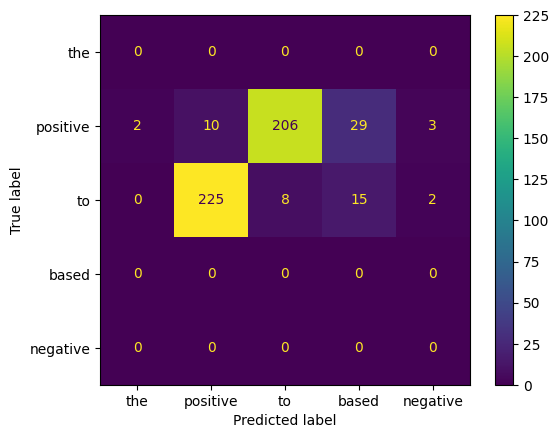

In [317]:
confusion_matrix(df_sample.sentiment, df_sample.response_m)

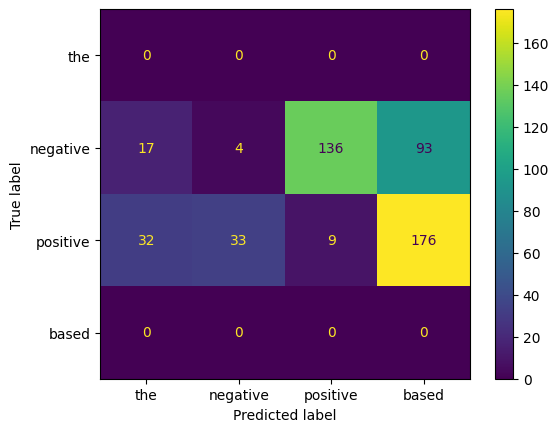

In [134]:
confusion_matrix(df_sample.sentiment, df_sample.response_s)

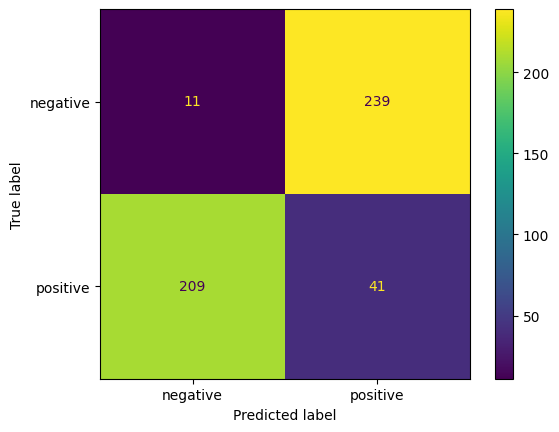

In [135]:
confusion_matrix(df_sample.sentiment, df_sample.response_m_log)

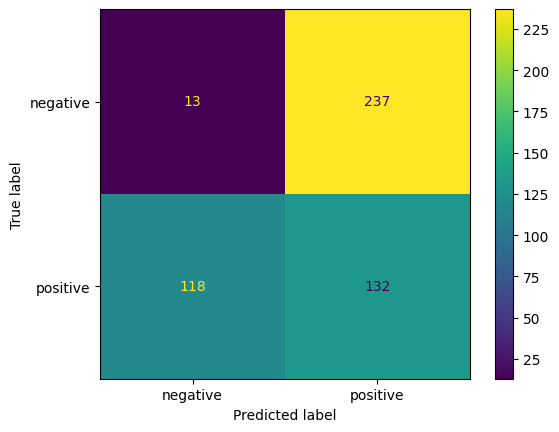

In [136]:
confusion_matrix(df_sample.sentiment, df_sample.response_s_log)

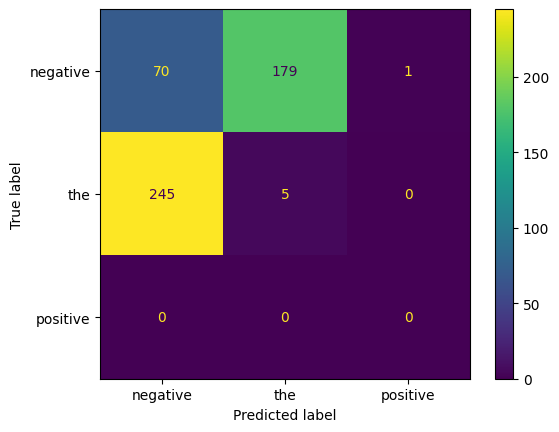

In [197]:
confusion_matrix(df_sample.sentiment, df_sample.response_m_k)

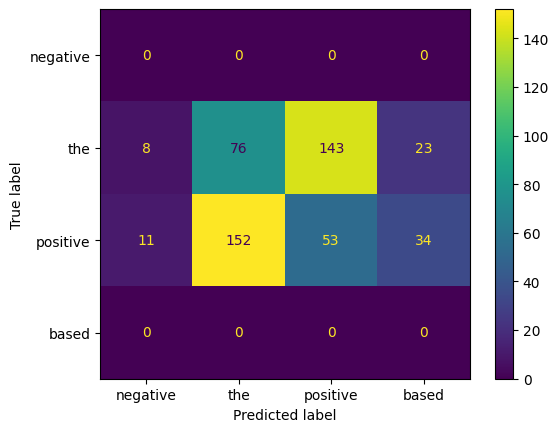

In [198]:
confusion_matrix(df_sample.sentiment, df_sample.response_s_k)

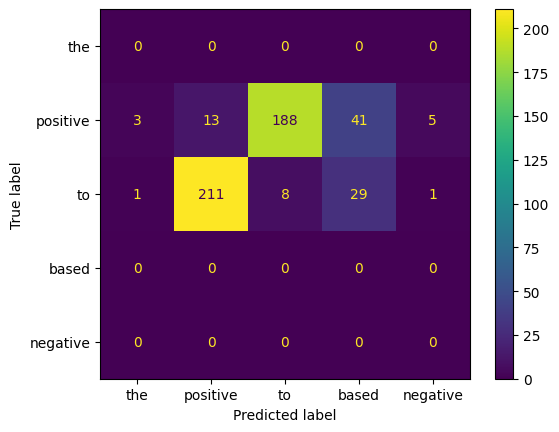

In [282]:
confusion_matrix(df_sample.sentiment, df_sample.response_m_samp)

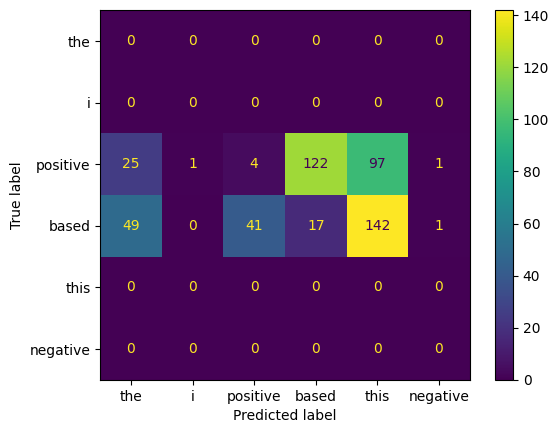

In [283]:
confusion_matrix(df_sample.sentiment, df_sample.response_s_samp)

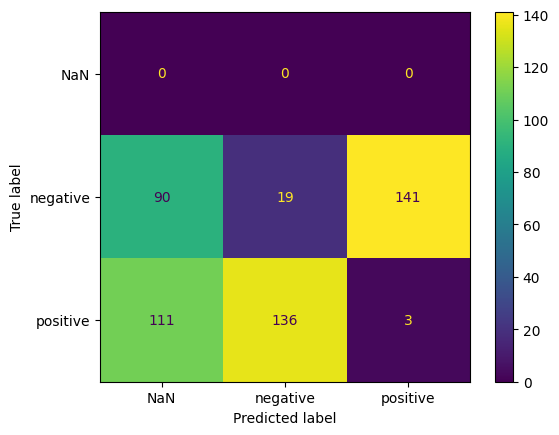

In [342]:
confusion_matrix(df_sample.sentiment, df_sample.response_m_cot)

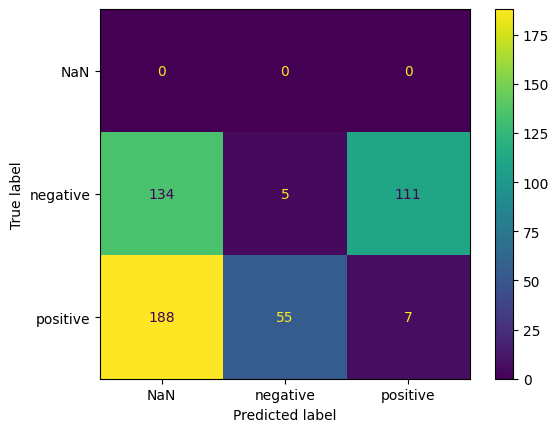

In [343]:
confusion_matrix(df_sample.sentiment, df_sample.response_s_cot)

-----------
## Appendix - accuracy and agreement plots

In this appendix we generate a bar plot of each model-method accuracy score summarized in the table above.

We also measure pairwise agreement scores among the different model-method predictions. We use macro F1-score for this purpose.
As observed on the confusion matrixes, this score reaches its maximum when comparing model predictions using method 2 (log-likelihood queries),
viz. 73%, indicating moderate agreement between the 1.5B and 500M models in this setting (for strong agreement a score $\geq$ 80% would be required).


In [503]:
# We create a dataframe of accuracy scores, for each model-method pair
acc_list = [
{'model': 'medium_zero',   'acc': accuracy(df_sample.sentiment, df_sample.response_m)},
{'model': 'small_zero',    'acc': accuracy(df_sample.sentiment, df_sample.response_s)},
{'model': 'medium_log' ,   'acc': accuracy(df_sample.sentiment, df_sample.response_m_log)},
{'model': 'small_log',     'acc': accuracy(df_sample.sentiment, df_sample.response_s_log)},
{'model': 'medium_5_shot', 'acc': accuracy(df_sample.sentiment, df_sample.response_m_k)},
{'model': 'small_5_shot',  'acc': accuracy(df_sample.sentiment, df_sample.response_s_k)},
{'model': 'medium_samp',   'acc': accuracy(df_sample.sentiment, df_sample.response_m_samp)},
{'model': 'small_samp',    'acc': accuracy(df_sample.sentiment, df_sample.response_s_samp)},
{'model': 'medium_cot' ,   'acc': accuracy(df_sample.sentiment, df_sample.response_m_cot)},
{'model': 'small_cot',     'acc': accuracy(df_sample.sentiment, df_sample.response_s_cot)}
]
# Dataframe of scores
acc_scores = pd.DataFrame(acc_list)

In [504]:
def plot_accuracy(scores:pd.DataFrame)->None:
    '''
    Function to display accuracy

    Arguments:
        - scores:    DataFrame of scores
    '''
    plt.bar(scores.model, scores.acc)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.xticks(range(0,scores.shape[0]+10), rotation=70, fontsize=8)
    plt.margins(0.05)
    plt.title('Accuracy Distribution')
    plt.show()

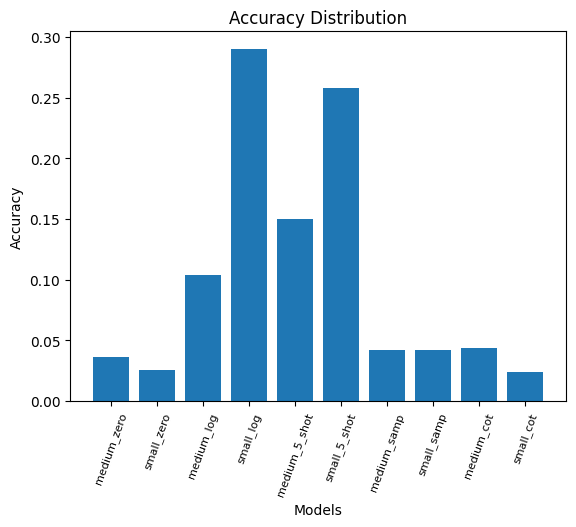

In [511]:
# Generate plot.
plot_accuracy(acc_scores)

In [508]:
# Now, we create a N-by-N matrix of agreement scores for each of the N model-method pairs.
pred_list = [
{'model': 'medium_zero',   'pred': df_sample.response_m},
{'model': 'small_zero',    'pred': df_sample.sentiment},
{'model': 'medium_log' ,   'pred': df_sample.response_m_log},
{'model': 'small_log',     'pred': df_sample.response_s_log},
{'model': 'medium_5_shot', 'pred': df_sample.response_m_k},
{'model': 'small_5_shot',  'pred': df_sample.response_s_k},
{'model': 'medium_samp',   'pred': df_sample.response_m_samp},
{'model': 'small_samp',    'pred': df_sample.response_s_samp},
{'model': 'medium_cot' ,   'pred': df_sample.response_m_cot},
{'model': 'small_cot',     'pred': df_sample.response_s_cot}
]
# Create table
agg_table = np.zeros((len(pred_list), len(pred_list)))
labels = []
for i in range(0, len(pred_list)):
    labels.append(pred_list[i]['model'])
    for j in range(i+1, len(pred_list)):
        agg_table[i,j] = agreement(pred_list[i]['pred'], 
                                   pred_list[j]['pred'], 
                                   average='macro', 
                                   zero_division=0)

In [509]:
def plot_agreement(scores:np.array, labels:list)->None:
    '''
    Function to display agreement scores

    Arguments:
        - scores:    array of scores
        - labels:    list of labels
    '''
    plt.imshow(scores) 
    plt.yticks(range(0,len(labels)), labels, fontsize=8)
    plt.xticks(range(0,len(labels)), labels, fontsize=8, rotation=90)
    # Loop over data dimensions to paste scores.
    for i in range(len(labels)):
        for j in range(i+1,len(labels)):
            text = plt.text(j, i, "%.2f" % scores[i, j],
                           ha="center", va="center", color="w", fontsize=8)
    plt.margins(0.05)
    plt.title('Model Pairwise Agreement Scores')
    plt.show()

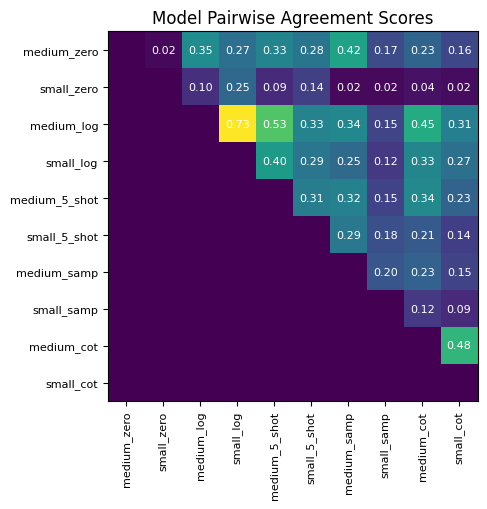

In [510]:
# Generate plot.
plot_agreement(agg_table, labels)